In [1]:
from pathlib import Path
from cobra.io import load_matlab_model, save_matlab_model,save_json_model
import logging
import cobra
from cobra.io import load_model
import pandas as pd
import random
import re

# Set M9 medium


In [2]:
M9_id = ['EX_co2(e)',
 'EX_glc_D(e)',
 'EX_h(e)',
 'EX_h2o(e)',
 'EX_k(e)',
 'EX_na1(e)',
 'EX_nh4(e)',
 'EX_o2(e)',
 'EX_cl(e)',
 'EX_pi(e)',
 'EX_so4(e)']

M9_medium = {'EX_co2(e)': 1000.0,
 'EX_cobalt2(e)': 1000.0,
 'EX_glc_D(e)': 10.0,
 'EX_h(e)': 1000.0,
 'EX_h2o(e)': 1000.0,
 'EX_k(e)': 1000.0,
 'EX_cu2(e)': 1000.0,
 'EX_mg2(e)': 1000.0,
 'EX_mn2(e)': 1000.0,
 #'EX_mobd(e)': 1000.0,
 'EX_na1(e)': 1000.0,
 'EX_nh4(e)': 1000.0,
 'EX_ca2(e)': 1000.0,
 'EX_cbl1(e)': 0.01,
 #'EX_ni2(e)': 1000.0,
 'EX_o2(e)': 1000.0,
 'EX_cl(e)': 1000.0,
 'EX_pi(e)': 1000.0,
 'EX_zn2(e)': 1000.0,
 'EX_sel(e)': 1000.0,
 #'EX_slnt(e)': 1000.0,
 'EX_so4(e)': 1000.0,
 #'EX_tungs(e)': 1000.0,
 'EX_fe2(e)': 1000.0,
 'EX_fe3(e)': 1000.0}

In [4]:
# change the absolute path
ecoli_model = load_matlab_model(
        "C:\\Users\\lenovo\\Desktop\\escher_2\\Escherichia_coli_MS_84_1.mat"
    )

No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, p


In [5]:
class ex_metabolites(object):
    def __init__(self, re_id, met_id, met_formula):
        self.re_id = re_id
        self.met_id = met_id
        self.met_formula = met_formula #str
    
    def calculate(self):
        elements = re.findall(r'([A-Z][a-z]*)(\d*)', self.met_formula)

        # 创建一个字典来存储元素和数量
        element_count = {}

        # 处理匹配的结果
        for element, count in elements:
            element_count[element] = int(count) if count else 1
        
        return element_count

def find_ex_metabolites(re_id, list):
    for member in list:
        if member.re_id == re_id:
            return member

In [6]:
m = []
for reaction in ecoli_model.exchanges:
    if reaction.id == 'EX_biomass(e)':
        m.append(ex_metabolites("EX_biomass(e)", "","B"))
        continue
    re_id = reaction.id
    met_id = str(re_id[3:]).replace('(', '[').replace(')', ']')
    m.append(ex_metabolites(re_id, met_id, ecoli_model.metabolites.get_by_id(met_id).formula))

In [7]:
m

# Add each metabolite into medium

In [11]:
with ecoli_model:
    #medium = list(ecoli_model.medium.keys())
    #ecoli_model.medium = {}

    # in M9 medium, some 1.0, others 0.007

    ecoli_model.medium = M9_medium
    for id in M9_medium:
        if id in M9_id:
            ecoli_model.reactions.get_by_id(id).lower_bound = -1.0
            ecoli_model.reactions.get_by_id(id).upper_bound = 100
        else:
            ecoli_model.reactions.get_by_id(id).lower_bound = -0.007
            ecoli_model.reactions.get_by_id(id).upper_bound = 100

    total_result = []
    result = []
    #print(ecoli_model.medium)

    # ecoli_model.reactions.get_by_id("EX_sheme(e)").lower_bound=-5
    # ecoli_model.reactions.get_by_id("EX_pheme(e)").lower_bound=-5
    
    # result.append((count, ecoli_model.slim_optimize()))
    

    '''
    random sequence
    '''
    n = len(ecoli_model.exchanges)
    added_rec = []
    
    seed = 500

    random.seed(seed)

    for i in range(len(ecoli_model.exchanges)):
        temp = find_ex_metabolites(ecoli_model.exchanges[i].id, m) # return class ex_metabolites

        added_rec.append(temp)

    for i in range(1):
        
        seed += 1
        result = []
        random_sequence = random.sample(range(n), n)
        #added_rec = []
        count = 0
        with ecoli_model:
            for i in random_sequence:
                
                if ecoli_model.exchanges[i].id in M9_medium:
                    continue
                else:
                    #print(count)
                    ecoli_model.exchanges[i].lower_bound = -0.01
                    count += 1

                    # temp = find_ex_metabolites(ecoli_model.exchanges[i].id, m) # return class ex_metabolites
                    # added_rec.append(temp)

                    
                    C_fluxes = 0
                    N_fluxes = 0
                    O_fluxes = 0
                    #opt_result = cobra.flux_analysis.pfba(ecoli_model)
                    opt_result = ecoli_model.optimize()
                    for rec in added_rec:
                        #print(rec)
                        if (rec.calculate().get('C',0) * opt_result[rec.re_id]) < 0:
                            C_fluxes += -rec.calculate().get('C',0) * opt_result[rec.re_id]
                        if (rec.calculate().get('N',0) * opt_result[rec.re_id]) < 0:
                            N_fluxes += -rec.calculate().get('N',0) * opt_result[rec.re_id]
                        if (rec.calculate().get('O',0) * opt_result[rec.re_id]) < 0:
                            O_fluxes += -rec.calculate().get('O',0) * opt_result[rec.re_id]

                        #print(C_fluxes)
                        #if (rec.calculate().get('C',0) * opt_result[rec.re_id]) > 0:
                            #print(rec.re_id,rec.calculate().get('C',0) * opt_result[rec.re_id])

                    #print(count, opt_result.objective_value, ecoli_model.exchanges[i].id, temp.calculate().get('C',0), C_fluxes)
                    
                    result.append((count, opt_result.objective_value, C_fluxes, N_fluxes, O_fluxes ,opt_result.fluxes['EX_ac(e)'], ecoli_model.exchanges[i].id))
            print(seed - 499)
            total_result.append(result)
# import json
# json_file = 'data4.json'
# with open(json_file, 'w') as f:
#     json.dump(total_result, f)

2


# each metabolites substitude the C,N,O

In [12]:
import json
json_file = 'data4.json'
with open(json_file, 'r') as f:
    total_result = json.load(f)
y1 = [point[1] for point in result]
C1 = [point[2] for point in total_result[0]] # C_fluxes
C2 = [point[3] for point in total_result[0]] # N_fluxes
C3 = [point[4] for point in total_result[0]] # O_fluxes
with ecoli_model:
    #medium = list(ecoli_model.medium.keys())
    #ecoli_model.medium = {}
    ecoli_model.medium = M9_medium
    for id in M9_medium:
        if id in M9_id:
            ecoli_model.reactions.get_by_id(id).lower_bound = -1.0
            ecoli_model.reactions.get_by_id(id).upper_bound = 100
        else:
            ecoli_model.reactions.get_by_id(id).lower_bound = -0.007
            ecoli_model.reactions.get_by_id(id).upper_bound = 100
    
    result2 = []
    result3 = []
    for rec in added_rec:
        if rec.calculate().get('C',0) == 0:
                continue
        ecoli_model.reactions.get_by_id('EX_glc_D(e)').lower_bound = 0
        for i in [0, len(C1)-1]:
            
            # Set C,N,O same
            ecoli_model.reactions.get_by_id(rec.re_id).lower_bound = -C1[i] / (rec.calculate().get('C',0))
            ecoli_model.reactions.get_by_id('EX_nh4(e)').lower_bound = min(-C2[i] + C1[i]*(rec.calculate().get('N',0)),0)
            ecoli_model.reactions.get_by_id('EX_o2(e)').lower_bound = -C3[i] / 2.0 -1
            
            opt_result = ecoli_model.optimize()

            result2.append([C1[i], opt_result.fluxes['EX_glc_D(e)'], opt_result.objective_value, opt_result.fluxes['EX_ac(e)']])
            #print(-C3[i] / 2.0 -1 + C1[i] / 6.0, opt_result.fluxes['EX_o2(e)'])

        print(opt_result.objective_value - y1[i], rec.re_id)
        result3.append([opt_result.objective_value - y1[i], rec.re_id, ecoli_model.metabolites.get_by_id(rec.met_id).name]) 
        ecoli_model.reactions.get_by_id(rec.re_id).lower_bound = 0

0.05821838879412031 EX_15dap(e)
-0.22206061034981792 EX_1hibup_S(e)
0.01673611608745104 EX_1hibupglu_S(e)
-0.22206061034981792 EX_1hmdgluc(e)
-0.22206061034981792 EX_1ohmdz(e)
0.39985756976237874 EX_2ddglcn(e)
-0.22206061034981792 EX_2dmmq8(e)
-0.22206061034981792 EX_2hatvacid(e)
-0.22206061034981792 EX_2hatvacidgluc(e)
-0.22206061034981792 EX_2hatvlac(e)
-0.22206061034981792 EX_2hatvlacgluc(e)
-0.22206061034981792 EX_2hibup_S(e)
0.016736116087448932 EX_2hibupglu_S(e)
-0.22206061034981792 EX_2hyoxplac(e)
0.2521627525005562 EX_2obut(e)
-0.22206061034981792 EX_2oh_cbz(e)
-0.22206061034981792 EX_2oh_cbz_glc(e)
-0.22206061034981792 EX_2oh_mtz(e)
-0.22206061034981792 EX_2oh_mtz_glc(e)
0.08015657995399036 EX_34dhpha(e)
-0.22206061034981792 EX_34dhphe(e)
-0.22206061034981792 EX_3hibup_S(e)
0.01673611608745021 EX_3hibupglu_S(e)
-0.006836025318979311 EX_3hphac(e)
-0.22206061034981792 EX_3meacmp(e)
-0.22206061034981792 EX_3oh_cbz(e)
-0.22206061034981792 EX_3oh_cbz_glc(e)
-0.22206061034981792 EX_

In [13]:
sorted_list = sorted(result3, key=lambda x: x[0])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


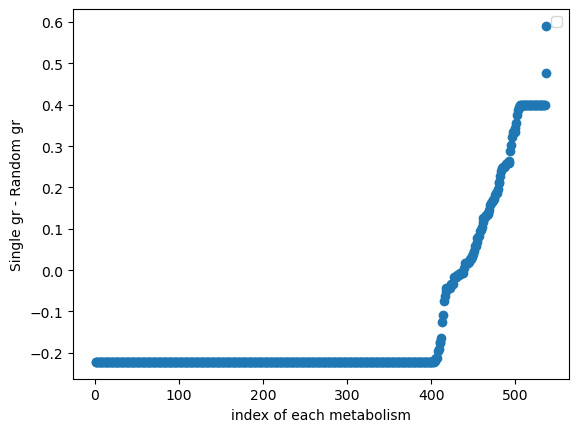

In [14]:
import matplotlib.pyplot as plt


# 从排序后的列表中提取value1和value2的值
value1 = [i+1 for i in range(len(sorted_list))]
value2 = [item[0] for item in sorted_list]

# 绘制散点图
plt.scatter(value1, value2)

# 添加标签和标题
plt.xlabel('index of each metabolism')
plt.ylabel('Single gr - Random gr')
#plt.title('Scatter Plot of Sorted List')

# 显示图形
plt.legend()
#plt.grid(True)
plt.show()

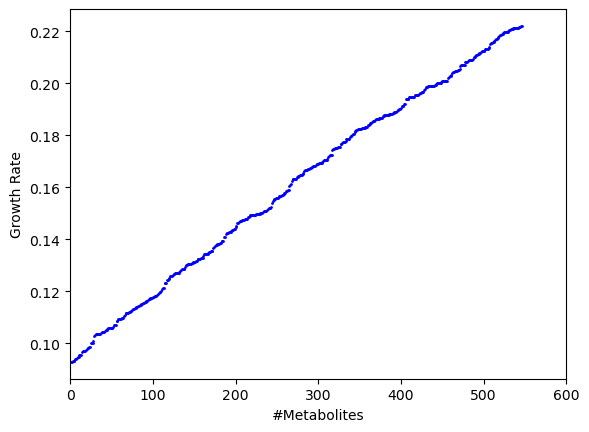

In [15]:
import matplotlib.pyplot as plt

result = total_result[0]
x = [point[0] for point in result]
y1 = [point[1] for point in result]
y2 = [point[2] for point in result]



plt.scatter(x, y1, s=1, color='b')

#plt.title('Scatter Plot of Points')
plt.xlabel('#Metabolites')
plt.ylabel('Growth Rate')
plt.xlim(0,600)

#plt.legend()

plt.show()

In [ ]:
# import numpy as np
# result =total_result[0]
# x = np.array([point[2] for point in result])
# y1 = np.array([point[1] for point in result])
# y2 = np.array([point[2] for point in result2])
# # 创建第一个 Y 轴
# fig, ax1 = plt.subplots()

# ax1.scatter(x, y1, color='b', s=1)  # 蓝色线条
# ax1.set_xlabel('C&N&O_fluxes')
# ax1.tick_params('x', labelcolor='w')
# ax1.set_ylabel('Growth Rate(/h)-random metabolites', color='b')
# ax1.tick_params('y', colors='b')
# ax1.set_ylim(0.08, 0.7)

# # 创建第二个 Y 轴
# ax2 = ax1.twinx()  # 共享相同的 X 轴

# ax2.scatter(x, y2, color='r',s=1)  # 红色线条
# ax2.set_ylabel('Growth Rate(/h)-M9 metabolites', color='r')
# ax2.tick_params('y', colors='r')
# ax2.set_ylim(0.08, 0.7)



# plt.show()